# Monte Carlo Integration

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, cauchy, uniform, norm, expon
from scipy.special import loggamma
from scipy.integrate import quad 
import scipy
import matplotlib.pyplot as plt

In [2]:
np.random.seed(3)

##### Example 3.1 and Figure 3.1

loggamma (lgamma in R) function returns the natural logarithm of the absolute value of gamma function (log gamma function) of the argument. The log gamma function of x is defined as:

$\Gamma(\lambda) = \ln \big | \int_{0}^{\infty} x^{\lambda-1} \exp (-x) \mathrm{d} x \big |$

In [3]:
lambda_values = np.linspace(0.01, 10, 100)

In [4]:
def gamma_fun(x, lambda_value):
    return x**(lambda_value-1)*np.exp(-x)
def integral_on_gamma(lambda_value):
    return quad(gamma_fun, 0, np.inf, args = lambda_value)[0]

In [5]:
gamma_integrals = np.vectorize(integral_on_gamma)(lambda_values)
scipy_loggamma = loggamma(lambda_values)

Text(0.5, 1.0, 'Integrate.quad function VS direct log-gamma calculation')

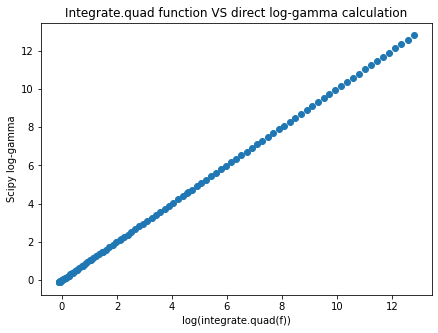

In [6]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x = np.log(gamma_integrals), y = scipy_loggamma)
ax.set_xlabel('log(integrate.quad(f))')
ax.set_ylabel('Scipy log-gamma')
ax.set_title('Integrate.quad function VS direct log-gamma calculation')

##### Example 3.2 and Figure 3.2 pag.63,64

This is not clear at all to me

In [7]:
def cauchy_product(the, cauchy_rvs):
    u = 1
    for i in range(10):
        u = u*cauchy.pdf(cauchy_rvs[1] - the) #why the theta is subtracted like this? In the formula (pag. 36) is under a quadratic operation 
    return u

In [8]:
cauchy_rvs = cauchy.rvs(size=10, loc = 350) 
quad(cauchy_product, -np.inf, np.inf, args = cauchy_rvs) #which should be the real value?

(6.471290919079487e-44, 1.2794160657758293e-43)

In [9]:
x = np.linspace(1, 10**3, 50)
y = []
for a in x:
    y.append(quad(cauchy_product, -a, a, args = cauchy_rvs)[0])

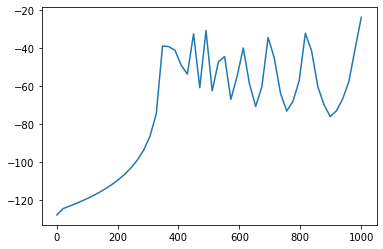

In [10]:
plt.plot(x, np.log(np.array(y)))

### Classical Monte Carlo Integration

##### Example 3.3 and Figure 3.3 pag.65,66,67

In [11]:
def h(x):
    return (np.cos(50*x)+np.sin(20*x))**2
quad(h, 0, 1)

(0.9652009360501453, 1.8542214725442152e-10)

In [12]:
Nsim = 10**4
x = h(uniform.rvs(size=Nsim))

In [13]:
estint = np.cumsum(x)/np.arange(1,Nsim+1)
print("Monte Carlo approximation: {}".format(estint[-1]))
esterr = np.sqrt(np.cumsum(x - estint)**2/(np.arange(1,Nsim+1)**2))

Monte Carlo approximation: 0.9677351205717744


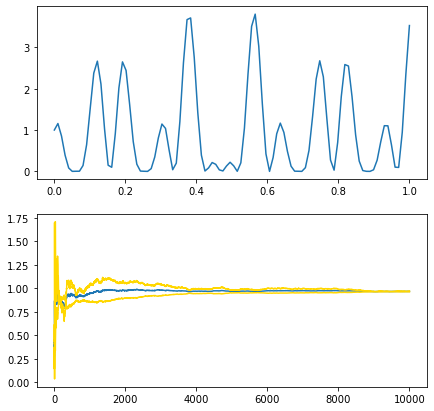

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(7,7))
ax1.plot(np.linspace(0, 1, 100), h(np.linspace(0, 1, 100)))

ax2.plot(np.arange(Nsim), estint)
ax2.plot(np.arange(Nsim), estint - 2*esterr, color ='gold')
ax2.plot(np.arange(Nsim), estint + 2*esterr, color ='gold')

##### Example 3.4

In [15]:
bound = norm.ppf([0.5, 0.75, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]) #bound values are what in the formula is called t   

In order to calculate the number of simulations I need to obtain a certain digit round precision, I have to do some calculus. First, as said (pag. 68), the exact variance is 

$\Phi(t)[1-\Phi(t)] / n$

Since this is a decreasing function (for a fixed n) for t = 0, 1, 2, ... (you can check empirically), the maximum variance is when t = 0. For  t = 0, the variance is thus approximately 
$$
\Phi(0)* (1-\Phi(0)) /n \\
0.5*(1-0.5)/n \\
0.25/n
$$

In order to achieve a precision of four decimals, at a 95% confidence interval, we want that 2*standard_error, is smaller than 0.0001 i.e.:

$$
2*\sqrt{0.25/n} \leq 10^{-4} \\
n = 10^8
$$

In general, n (the number of simulations needed) can be calculated like this:

$$
2*\sqrt{\Phi(t)* (1-\Phi(t)) /n} \leq 10^{-k}\\
\frac{\Phi(t)* (1-\Phi(t))}{n} = \frac{10^{-2k}} {4}\\
\frac{n}{\Phi(t)* (1-\Phi(t))} = 4* 10^{2k}\\
n = 4* 10^{2k}*{\Phi(t)* (1-\Phi(t))}\\
n = 4* 10^{2k}*0.25 \\
\text{the above formula is because the maximum variance is when t = 0}\\
n = 10^{2k} \\
$$

where k is the number of digits I want to be precise

In [16]:
k = 4

Nsim = 10**(2*k)
x = norm.rvs(size = Nsim) #whole sample

In [17]:
diz = {}
digit_round = 4
for i in range(2,2*k+1): #lengthy loop
    for j in range(len(bound)):
        nsim = 10**i
        t = bound[j]
        mc_estimation = np.mean(x[1:nsim] < t)
        d = {t: mc_estimation}
        if nsim in diz.keys():
            diz[nsim].update(d) 
        else:
            diz[nsim] = d
table3_1 = pd.DataFrame.from_dict(diz, 'index')

In [18]:
table3_1

,0.000000,0.674490,0.841621,1.281552,1.644854,2.326348,3.090232,3.719016
100,0.595960,0.777778,0.797980,0.878788,0.949495,0.979798,1.000000,1.000000
1000,0.496496,0.741742,0.796797,0.889890,0.949950,0.988989,0.998999,1.000000
10000,0.496350,0.755076,0.805781,0.899090,0.952195,0.991999,0.999200,0.999900
100000,0.500075,0.752788,0.802318,0.900249,0.949449,0.990470,0.998990,0.999890
1000000,0.499336,0.749875,0.799864,0.899584,0.949977,0.990070,0.999017,0.999907
10000000,0.499735,0.749942,0.799924,0.899986,0.949969,0.989961,0.999001,0.999898
100000000,0.499972,0.749915,0.799937,0.899988,0.949997,0.990002,0.998997,0.999898


##### Exercise 3.1 pag.66

a. Plot the integrands, and use Monte Carlo integration based on a Cauchy simulation to calculate the integrals.

In [19]:
Nsim = 10**4
xs = [0, 2, 4]

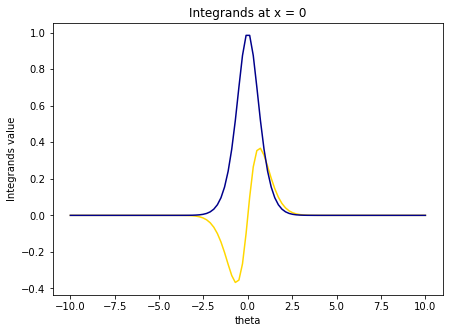

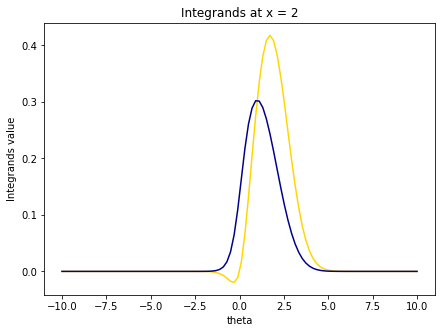

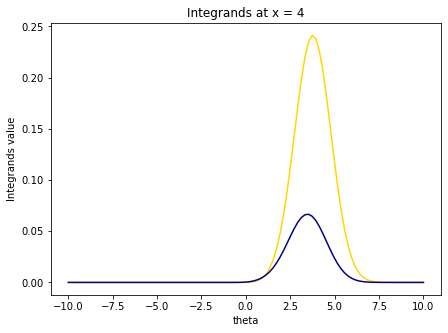

In [20]:
def f1(t, x):
    return t/(1+(t)**2)*np.exp( - ((x -t)**2) / 2)
def f2(t, x):
    return 1/(1+(t)**2)*np.exp( - ((x -t)**2) / 2)

#plot the integrands
#fig, ax = plt.subplots(figsize=(7,5))
x_axis = np.linspace(-10, 10, 100)
for x in xs:
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(x_axis, f1(x_axis, x), color ='gold',  label = 'f1')
    ax.plot(x_axis, f2(x_axis, x), color ='darkblue', label = 'f2')
    ax.set_ylabel('Integrands value')
    ax.set_title('Integrands at x = {}'.format(x))
    ax.set_xlabel('theta')
    plt.show()

In [21]:
#I really don't understand why they say: 
#Both numerator and denominator are expectations under the Cauchy distribution (exercise solutions pdf)
# So I dont fully understand this calculus
co = cauchy.rvs(size=Nsim)
for x in xs:
    I=np.mean(co*norm.pdf(co, loc = x))/np.mean(norm.pdf(co, loc = x))
    print(I)

8.041303781086726e-05
1.2792729517436459
3.443607313444783


b. Monitor the convergence with the standard error of the estimate. Obtain three digits of accuracy with probability .95.

Monte Carlo approximation on first integrand: 0.07906840232503827
Monte Carlo approximation on second integrand: 0.0229609229880344


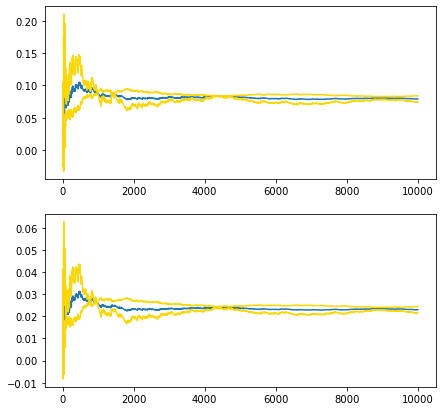

In [22]:
x1 = norm.pdf(co, loc = x)
estint2 = np.cumsum(x1)/np.arange(1,Nsim+1)
esterr2 = np.sqrt(np.cumsum(x1 - estint2)**2/(np.arange(1,Nsim+1)**2))
x1 = co*x1
estint1 = np.cumsum(x1)/np.arange(1,Nsim+1)
esterr1 = np.sqrt(np.cumsum(x1 - estint1)**2/(np.arange(1,Nsim+1)**2))
print("Monte Carlo approximation on first integrand: {}".format(estint1[-1]))
print("Monte Carlo approximation on second integrand: {}".format(estint2[-1]))

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(7,7))
ax1.plot(np.arange(Nsim), estint1)
ax1.plot(np.arange(Nsim), estint1 - 2*esterr1, color ='gold')
ax1.plot(np.arange(Nsim), estint1 + 2*esterr1, color ='gold')

ax2.plot(np.arange(Nsim), estint2)
ax2.plot(np.arange(Nsim), estint2 - 2*esterr2, color ='gold')
ax2.plot(np.arange(Nsim), estint2 + 2*esterr2, color ='gold')

I want 3 digits of accuracy.

$$
\frac{2*\sigma}{\sqrt{n}} \leq 10^{-3} \\
\frac{1}{\sqrt{n}} \leq \frac{1}{10^{3} * 2 *\sigma} \\
n = 10^{6} * 4 *\sigma^2 \\
$$


In [23]:
for x in xs:
    empirical_variance1 = np.var(co*norm.pdf(co,loc=x))
    empirical_variance2 = np.var(norm.pdf(co,loc=x))
    Nsim_required = max((10**6)*4*empirical_variance1, (10**6)*4*empirical_variance2)#why max?
    print(Nsim_required)

98368.29066263481
213341.0228666251
315376.8362026164


c. Repeat the experiment with a Monte Carlo integration based on a normal simulation and compare both approaches.

In [24]:
#This I really dont understand

##### Exercise 3.2 pag.69

Given that $\mathbb{I}_{X_{i} \leq t}$ is a Bernoulli random variable equal to 1 with probability $\Phi(t)$, show that the variance of the normalized estimator $\mathbb{I}_{X_{i} \leq t} / \Phi(t)$ goes to infinity when $t$ decreases to $-\infty$. Deduce the number of simulations (as a function of $t$) that are necessary to achieve a variance less than $10^{-8}$.

The variance of a Bernoulli variable $\mathbb{I}_{X_{i} \leq t}$ is $\Phi(t)[1-\Phi(t)]$.

Let's now calculate the variance of $\frac{\mathbb{I}_{X_{i} \leq t}}{\Phi(t)}$.

$$
Var \bigg [ \frac{\mathbb{I}_{X_{i} \leq t}}{\Phi(t)} \bigg ] =
E \bigg [ \bigg ( \frac{\mathbb{I}_{X_{i} \leq t}}{\Phi(t)} \bigg )^2 \bigg ] - E \bigg [  \frac{\mathbb{I}_{X_{i} \leq t}}{\Phi(t)} \bigg ]^2 = \\
\frac{1}{\Phi(t)^2} E \bigg [ \mathbb{I}_{X_{i} \leq t}^2 \bigg ] - \frac{1}{\Phi(t)} E \bigg [  \mathbb{I}_{X_{i} \leq t} \bigg ]^2 = \\
\frac{1}{\Phi(t)^2} E \bigg [ \mathbb{I}_{X_{i} \leq t} \bigg ] - \frac{1}{\Phi(t)} E \bigg [  \mathbb{I}_{X_{i} \leq t} \bigg ]^2 = \\
\frac{1}{\Phi(t)^2} \Phi(t) - \frac{1}{\Phi(t)} \Phi(t)^2 = \\
\frac{1}{\Phi(t)} - {\Phi(t)} = \\
\frac{1 - \Phi(t)^2}{\Phi(t)}
$$


In [25]:
Nsim = 10**4
x = norm.rvs(size = Nsim) #The same x of example 3.4


t_values = norm.ppf(np.linspace(0.00001, 0.999999, 50)) #norm.ppf(np.linspace(0.999999, 0.1, 50))
empirical_variances = []
for t in t_values:  # bounds values are t values
    mc_estimation = np.mean(x < t)
    variance_estimation = (1 - mc_estimation**2)/mc_estimation
    empirical_variances.append(variance_estimation)

/var/folders/jw/2zcyhtb14rsd02rj1vtd10yh0000gn/T/ipykernel_79829/3048270001.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  variance_estimation = (1 - mc_estimation**2)/mc_estimation


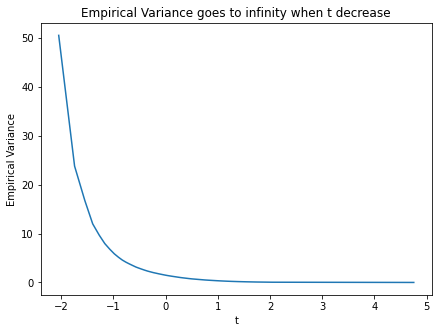

In [26]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(t_values,  empirical_variances)
ax.set_ylabel('Empirical Variance')
ax.set_title('Empirical Variance goes to infinity when t decrease')
ax.set_xlabel('t')
plt.show()

The higher variance is when $t = - \infty$. The smaller variance is when $t = + \infty$. 

I don't know how to solve this: 

Deduce the number of simulations (as a function of $t$) that are necessary to achieve a variance less than $10^{-8}$.

##### Exercise 3.3 pag.69
If we are interested in the tail probability $\operatorname{Pr}(X>20)$ when $X \sim \mathcal{N}(0,1)$, simulating from a $\mathcal{N}(0,1)$ distribution does not work. Express the probability as an integral and use an obvious change of variable to rewrite this integral as an expectation under a $\mathcal{U}(0,1 / 20)$ distribution. Deduce a Monte Carlo approximation to $\operatorname{Pr}(X>20)$ along with an error assessment.

I don't even understand the solution.

### Importance Sampling

##### Exercise 3.4 Pag. 70

For the computation of the expectation $\mathbb{E}_{f}[h(X)]$ when $f$ is the normal pdf and $h(x)=\exp \left(-(x-3)^{2} / 2\right)+\exp \left(-(x-6)^{2} / 2\right)$ :

a. Show that $\mathbb{E}_{f}[h(X)]$ can be computed in closed form and derive its value.

b. Construct a regular Monte Carlo approximation based on a normal $\mathcal{N}(0,1)$ sample of size Nsim=10^3 and produce an error evaluation.

c. Compare the above with an importance sampling approximation based on an importance function $g$ corresponding to the $\mathcal{U}(-8,-1)$ distribution and a sample of size Nsim=10^3. (Warning: This choice of $g$ does not provide a converging approximation of $\left.\mathbb{E}_{f}[h(X)] !\right)$

a.

$$
\mathbb{E}_{f}[h(X)] = \int_{-\infty}^{\infty} h(x) f(x) dx = \\
\frac{1}{\sqrt{2 \pi}} \int\left(e^{-\frac{(x-3)^{2}}{2}}+e^{-\frac{(x-6)^{2}}{2}}\right) e^{-\frac{x^{2}}{2}} dx = \\
\frac{1}{\sqrt{2 \pi}} \int e^{\frac{-(x-3)^{2}-x^2}{2}} dx + \frac{1}{\sqrt{2 \pi}} \int e^{\frac{-(x-6)^{2}-x^2}{2}} dx = \\
\frac{1}{\sqrt{2 \pi}} \int e^{\frac{-x^2+6x-9-x^2}{2}} dx +
\frac{1}{\sqrt{2 \pi}} \int e^{\frac{-x^2+12x-36-x^2}{2}} dx\\
\frac{1}{\sqrt{2 \pi}} \int e^{-x^2+3x-\frac{9}{2}} dx + 
\frac{1}{\sqrt{2 \pi}} \int e^{-x^2+6x-18} dx \\
\frac{1}{\sqrt{2 \pi}} \int e^{-(x^2-3x+\frac{9}{4})+\frac{9}{4}- \frac{9}{2}} dx + 
\frac{1}{\sqrt{2 \pi}} \int e^{-(x^2-6x+9)+9 - 18} dx\\
\frac{1}{\sqrt{2 \pi}} \int e^{-(x-\frac{3}{2})^2-\frac{9}{4}} dx + 
\frac{1}{\sqrt{2 \pi}} \int e^{-(x-3)^2-9} dx\\
\frac{1}{\sqrt{2 \pi}} \frac{\sqrt{2}}{\sqrt{2}}\int e^{-(x-\frac{3}{2})^2-\frac{9}{4}} dx + 
\frac{1}{\sqrt{2 \pi}} \frac{\sqrt{2}}{\sqrt{2}} \int e^{-(x-3)^2-9} dx\\
e^{-\frac{9}{4}}\frac{1}{\sqrt{2 \pi}} \frac{\sqrt{2}}{\sqrt{2}}\int e^{-(x-\frac{3}{2})^2} dx+ 
e^{-9}\frac{1}{\sqrt{2 \pi}} \frac{\sqrt{2}}{\sqrt{2}} \int e^{-(x-3)^2} dx\\
\text{We have 2 normals with sigma = 2^-(1/2)} \\
\frac{-e^{\frac{9}{4}} - e^{9}}{\sqrt2} = 0.0746
$$
Here is where I found the solution
https://edisciplinas.usp.br/pluginfile.php/6205968/mod_resource/content/1/aula4slidesE.pdf

b

ANALITICAL WAY

\begin{gathered}
\mathbb{E}_{f}[h(X)] = \mathbb{E}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}\right) + 
\mathbb{E}_{f}\left(e^{-\frac{(X-6)^{2}}{2}}\right) \\
\operatorname{Var}_{f}[h(X)] = \operatorname{Var}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}\right) + 
\operatorname{Var}_{f}\left(e^{-\frac{(X-6)^{2}}{2}}\right) + 
2 \operatorname{cov}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}, e^{-\frac{(X-6)^{2}}{2}}\right)\\
\\
\\
\\
\\
\\
\mathbb{E}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}\right)=\frac{e^{-9 / 4}}{\sqrt{2}}, \quad \mathbb{E}_{f}\left(e^{-\frac{(X-6)^{2}}{2}}\right)=\frac{e^{-9}}{\sqrt{2}} \\
\mathbb{E}_{f}\left(e^{-(X-3)^{2}}\right)=\frac{1}{\sqrt{2 \pi}} \int e^{-\frac{3}{2}(x-2)^{2}-3} d x=\frac{e^{-3}}{\sqrt{3}} \\
\mathbb{E}_{f}\left(e^{-(X-6)^{2}}\right)=\frac{1}{\sqrt{2 \pi}} \int e^{-\frac{3}{2}(x-4)^{2}-12} d x=\frac{e^{-12}}{\sqrt{3}} \\
\operatorname{Var}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}\right) = 
\mathbb{E}_{f}\left[\left(e^{-\frac{(X-3)^{2}}{2}}\right)^2\right] - 
\left[\mathbb{E}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}\right)\right]^2 = \\
 = \mathbb{E}_{f}\left(e^{-(X-3)^{2}}\right) - \left[\mathbb{E}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}\right)\right]^2 =
\frac{e^{-3}}{\sqrt{3}}-\frac{e^{-9 / 2}}{2} \\
\operatorname{Var}_{f}\left(e^{-\frac{(X-6)^{2}}{2}}\right) = 
\mathbb{E}_{f}\left[\left(e^{-\frac{(X-6)^{2}}{2}}\right)^2\right] - 
\left[\mathbb{E}_{f}\left(e^{-\frac{(X-6)^{2}}{2}}\right)\right]^2 = \\
 = \mathbb{E}_{f}\left(e^{-(X-6)^{2}}\right) - \left[\mathbb{E}_{f}\left(e^{-\frac{(X-6)^{2}}{2}}\right)\right]^2 =
\frac{e^{-12}}{\sqrt{3}}-\frac{e^{-18}}{2} \\
\mathbb{E}_{f}\left(e^{-\frac{(X-3)^{2}}{2}} e^{-\frac{(X-6)^{2}}{2}}\right)=\frac{1}{\sqrt{2 \pi}} \int e^{-\frac{3}{2}(x-3)^{2}-9} d x=\frac{e^{-9}}{\sqrt{3}} \\
\operatorname{cov}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}, e^{-\frac{(X-6)^{2}}{2}}\right)=
\mathbb{E}_{f}\left(e^{-\frac{(X-3)^{2}}{2}} e^{-\frac{(X-6)^{2}}{2}}\right) - \mathbb{E}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}\right)\mathbb{E}_{f}\left(e^{-\frac{(X-6)^{2}}{2}}\right) = 
\frac{e^{-9}}{\sqrt{3}}-\frac{e^{-(9 / 4+9)}}{2} .
\\
\\
\\
\operatorname{Var}_{f}[h(X)] = \operatorname{Var}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}\right) + 
\operatorname{Var}_{f}\left(e^{-\frac{(X-6)^{2}}{2}}\right) + 
2 \operatorname{cov}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}, e^{-\frac{(X-6)^{2}}{2}}\right) = \\ 
=\frac{e^{-3}}{\sqrt{3}}-\frac{e^{-9 / 2}}{2}+\frac{e^{-12}}{\sqrt{3}}-\frac{e^{-18}}{2}+2\left(\frac{e^{-9}}{\sqrt{3}}-\frac{e^{-(9 / 4+9)}}{2}\right) \\
=\frac{e^{-3}+e^{-12}+2 e^{-9}}{\sqrt{3}}-\frac{e^{-9 / 2}+e^{-18}+2 e^{-(9 / 4+9)}}{2} \cong 0.0233 \\
r^{0.5} = 0.6745 \sqrt{\frac{0.0233}{n}} \cong 0.0032 \\
r^{0.95} = 1.96 \sqrt{\frac{0.0233}{n}} \cong 0.0094 \\
\\
\\
\\
C I_{95 \%}\left(\mathbb{E}_{f}\left(e^{-\frac{(X-3)^{2}}{2}}+e^{-\frac{(X-6)^{2}}{2}}\right)\right) \cong 0.0776 \pm 0.0094 \rightarrow(0.0682,0.087)
\end{gathered}

COMPUTATIONAL (empirical) WAY
$$
\bar{h}_{n}=\frac{1}{n} \sum_{j=1}^{n} h\left(x_{j}\right) \\
\hat{\operatorname{var}\left({h}_{n}\right)}= \frac{1}{n-1} \sum_{j=1}^{n}\left[h\left(x_{j}\right)-\bar{h}_{n}\right]^{2} .
$$

In [27]:
Nsim = 10**3
x = norm.rvs(size = Nsim)
y = np.exp(-(x-3)**2 /2) + np.exp(-(x-6)**2 /2)
mc_estimate = np.mean(y) #mean(h_n)
variance_estimate = 1/(Nsim - 1) * np.sum((y - mc_estimate)**2)
print(np.round(mc_estimate,4),  np.round(variance_estimate,4))

0.0728 0.0192


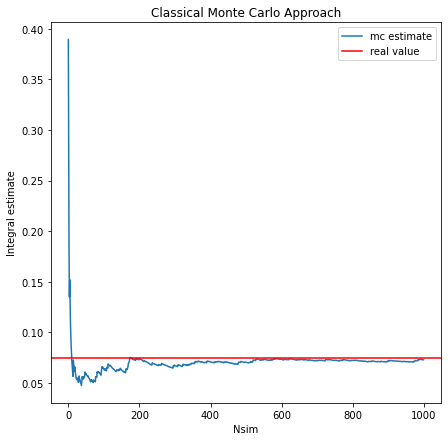

In [28]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.plot(np.arange(Nsim), np.cumsum(y)/np.arange(1,Nsim+1), label = 'mc estimate')
ax.axhline(0.0746, color = 'r', label = 'real value') #1-norm.cdf(4.5) is like norm.cdf(-4.5)
ax.set_xlabel('Nsim')
ax.set_ylabel('Integral estimate')
ax.set_title('Classical Monte Carlo Approach')
ax.legend()

c

The warning "This choice of $g$ does not provide a converging approximation of $\left.\mathbb{E}_{f}[h(X)] !\right)$" is because the support of $g$ is $[-8, -1]$ and the support of $h \times f$ is $(- \inf, + \inf)$. As stated in page 70, if $\operatorname{supp}(g) \not\subset \operatorname{supp}(h \times f)$, then we expect a biased result.

ANALITICAL WAY
$$
\mathbb{E}_{f}[h(X)] = \int_{\mathcal{X}} \frac{h(x) f(x)}{g(x)}g(x) dx = 
\mathbb{E}_{g} \left[ \frac{h(x) f(x)}{g(x)} \right] \\
= \mathbb{E}_{g} \left[ \frac{1}{\sqrt{2 \pi}} \frac{ e^{-\frac{x^{2}}{2}}}{\frac{1}{-1+8}} h(x) \right] =
\mathbb{E}_{g} \left[ \frac{7e^{-\frac{x^{2}}{2}}}{\sqrt{2 \pi}} h(x) \right] = \\
\int_{-8}^{-1} \frac{7}{7} \frac{1}{\sqrt{2 \pi}} \left(e^{-\frac{(x-3)^{2}}{2}}+e^{-\frac{(x-6)^{2}}{2}}\right) e^{-\frac{x^{2}}{2}} dx = \\
\int_{-8}^{-1} \frac{1}{\sqrt{2 \pi}} \left(e^{-\frac{(x-3)^{2}}{2}}+e^{-\frac{(x-6)^{2}}{2}}\right) e^{-\frac{x^{2}}{2}} dx
$$
The above equation may be can be calculate analitically somehow. Anyway, we can see that it's different from $\mathbb{E}_{f}[h(X)]$ (see equation in exercise a).

COMPUTATIONAL WAY
I can use the following estimator (pag. 70)
$$
\frac{1}{n} \sum_{j=1}^{n} \frac{f(X_j)}{g(X_j)} h(X_{j})
\\
\\
\\
\frac{1}{n} \sum_{j=1}^{n} \frac{7e^{-\frac{X_j^{2}}{2}}}{\sqrt{2 \pi}} \left(e^{-\frac{(X_j-3)^{2}}{2}}+e^{-\frac{(X_j-6)^{2}}{2}}\right)
$$
where $X_j ∼ \mathcal{U}(-8,-1)$

In [29]:
Nsim = 10**3
x = uniform.rvs(size = Nsim, loc = -8, scale = 7)
y = 7 * np.exp(- x**2 / 2)/np.sqrt(2*np.pi)*\
                              (np.exp(-(x-3)**2 /2) + np.exp(-(x-6)**2 /2))
mc_estimate = np.mean(y)

In [30]:
mc_estimate

1.1427258708244954e-05

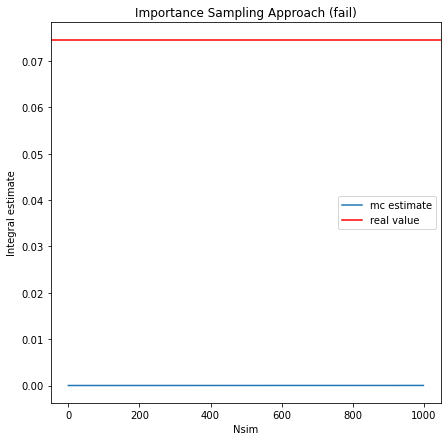

In [31]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.plot(np.arange(Nsim), np.cumsum(y)/np.arange(1,Nsim+1), label = 'mc estimate')
ax.axhline(0.0746, color = 'r', label = 'real value') #1-norm.cdf(4.5) is like norm.cdf(-4.5)
ax.set_xlabel('Nsim')
ax.set_ylabel('Integral estimate')
ax.set_title('Importance Sampling Approach (fail)')
ax.legend()

##### This are my considerations (not anymore the exercise) 

As we can see, the estimate is vary bad. This is because, as we said, $\operatorname{supp}(g) \not\subset \operatorname{supp}(h \times f)$. We can try now to see if the results is better if we try to give to g a support which is more likely to be representative of the domain $(-inf, inf)$. Let's try for example to sample from $\mathcal{U}(-1000,-1000)$. In this case, we can say that $\operatorname{supp}(g) = [-1000, 1000] \approx \operatorname{supp}(h \times f)$.

In this case, our estimator is:
$$
\frac{1}{n} \sum_{j=1}^{n} \frac{2000e^{-\frac{X_j^{2}}{2}}}{\sqrt{2 \pi}} \left(e^{-\frac{(X_j-3)^{2}}{2}}+e^{-\frac{(X_j-6)^{2}}{2}}\right)
$$

In [32]:
Nsim = 10**5 #I add more samples to be more precise
x = uniform.rvs(size = Nsim, loc = -1000, scale = 2000)
y = 2000 * np.exp(- x**2 / 2)/np.sqrt(2*np.pi)*\
                              (np.exp(-(x-3)**2 /2) + np.exp(-(x-6)**2 /2))
mc_estimate = np.mean(y)

In [33]:
mc_estimate #The result is much better!

0.07323575880715792

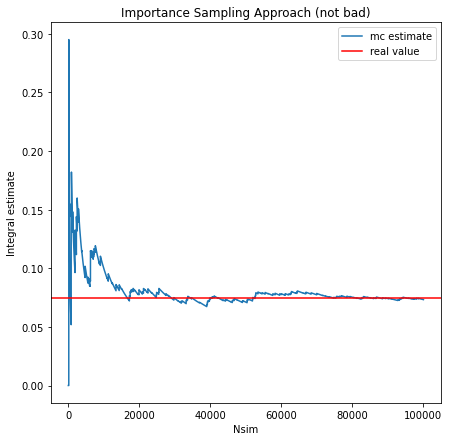

In [34]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.plot(np.arange(Nsim), np.cumsum(y)/np.arange(1,Nsim+1), label = 'mc estimate')
ax.axhline(0.0746, color = 'r', label = 'real value') #1-norm.cdf(4.5) is like norm.cdf(-4.5)
ax.set_xlabel('Nsim')
ax.set_ylabel('Integral estimate')
ax.set_title('Importance Sampling Approach (not bad)')
ax.legend()

##### Example 3.5 Pag. 70-71

In [35]:
Nsim = 10**3
y =  expon.rvs(loc = 4.5, size = Nsim)#g(y)
weit = norm.pdf(y)/expon.pdf(y, loc = 4.5)
est = np.cumsum(weit)/np.arange(1,Nsim+1)

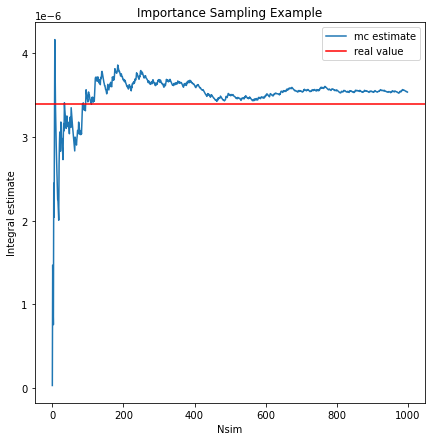

In [36]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.plot(np.arange(Nsim), est, label = 'mc estimate')
ax.axhline(1-norm.cdf(4.5), color = 'r', label = 'real value') #1-norm.cdf(4.5) is like norm.cdf(-4.5)
ax.set_xlabel('Nsim')
ax.set_ylabel('Integral estimate')
ax.set_title('Importance Sampling Example')
ax.legend()

##### Exercise 3.5

When $Z \sim \mathcal{N}(0,1)$, with density $f$, the quantity of interest is $\mathbb{P}(Z>4.5)$, i.e. $\mathbb{E}^{f}\left[\mathbb{I}_{Z>4.5}\right]$. When $g$ is the density of the exponential $\mathcal{E} x p(\lambda)$ distribution truncated at $4.5$,
$$
g(y)=\frac{1_{y>4.5} \lambda \exp (-\lambda y)}{\int_{-4.5}^{\infty} \lambda \exp (-\lambda y) \mathrm{d} y}=\lambda e^{-\lambda(y-4.5)} \mathbb{I}_{y>4.5},
$$
simulating iid $Y^{(i)}$ 's from $g$ is straightforward. Given that the indicator function $\mathbb{I}_{Y>4.5}$ is then always equal to $1, \mathbb{P}(Z>4.5)$ is estimated by
$$
\hat{h}_{n}=\frac{1}{n} \sum_{i=1}^{n} \frac{f\left(Y^{(i)}\right)}{g\left(Y^{(i)}\right)} .
$$
A corresponding estimator of its variance is
$$
v_{n}=\frac{1}{n} \sum_{i=1}^{n}\left(1-\hat{h}_{n}\right)^{2} f\left(Y^{(i)}\right) / g\left(Y^{(i)}\right) .
$$
The following Python code monitors the convergence of the estimator with different values of lambda.

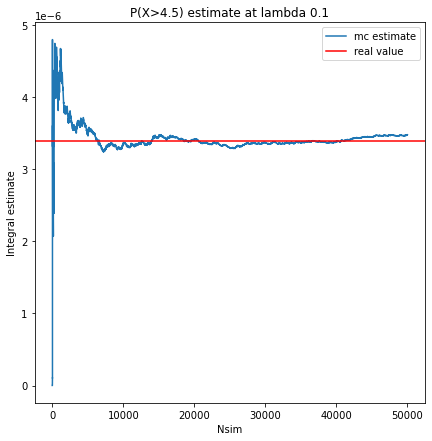

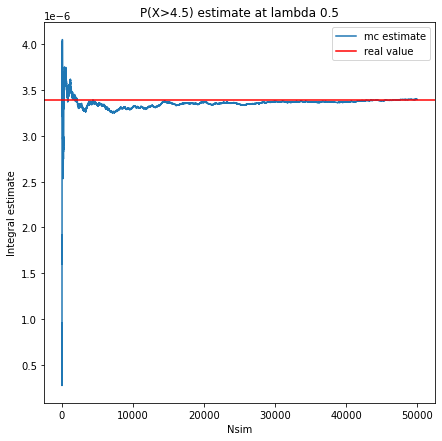

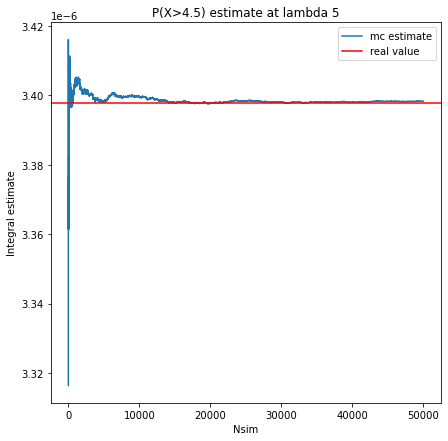

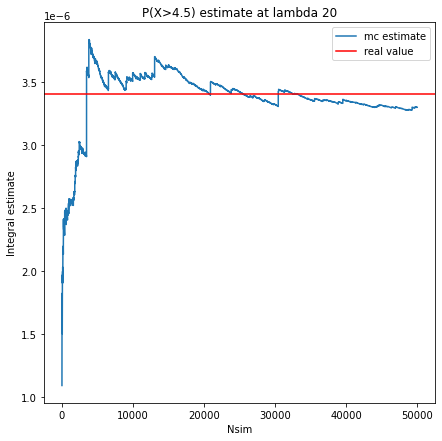

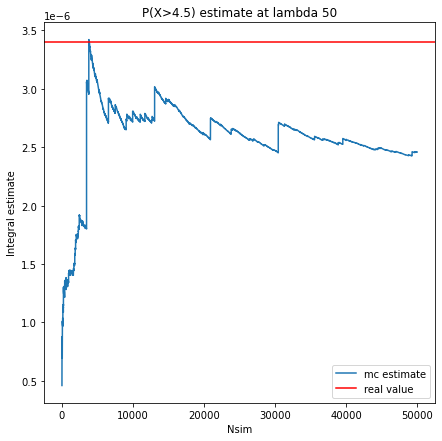

In [37]:
Nsim=5*(10**4)
x =  expon.rvs(size = Nsim)
lambda_values = [.1, .5, 5, 20, 50]
for la in lambda_values:
    y = x/la + 4.5
    weit = norm.pdf(y)/expon.pdf(y, loc = 4.5, scale = 1/la)
    est = np.cumsum(weit)/np.arange(1,Nsim+1)
    varest = (np.cumsum(weit)**2 * weit) / (np.arange(1,Nsim+1))**2
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    ax.plot(np.arange(Nsim), est, label = 'mc estimate')
    ax.axhline(1-norm.cdf(4.5), color = 'r', label = 'real value') #1-norm.cdf(4.5) is like norm.cdf(-4.5)
    ax.set_xlabel('Nsim')
    ax.set_ylabel('Integral estimate')
    ax.set_title('P(X>4.5) estimate at lambda {}'.format(la))
    ax.legend()

When evaluating the impact of λ on the variance (and hence on the conver- gence) of the estimator, similar graphs can be plotted for different values of λ. This experiment does not exhibit a clear pattern, even though large values of λ, like λ = 20 appear to slow down convergence very much. Figures above show the output of such a comparison. Picking $λ \leq 5$ seems however to produce a very stable approximation of the tail probability.